In [1]:
import torch
import re

from torchvision import models, datasets, transforms
import os
import time

In [4]:

data_dir = 'D:/NEUB/MachineLearning/ThesisProject/Eye_Disease_Dataset/Splited_Dataset(0.8,0.1,0.1)'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((254, 254)),
#         transforms.RandomGrayscale(p=0.3),
        transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomRotation(degrees=(-10, 10)),
#         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomCrop((215,215)),
        transforms.ToTensor(),
#         custom_normalize
        transforms.Normalize([0.0014, 0.0012, 0.0007],[0.0007, 0.0006, 0.0004])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
#         custom_normalize
        transforms.Normalize([0.0014, 0.0012, 0.0007],[0.0007, 0.0006, 0.0004])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
#         custom_normalize
        transforms.Normalize([0.0014, 0.0012, 0.0007],[0.0007, 0.0006, 0.0004])
    ])
}

# Load the datasets and apply the transformations
img_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ['train', 'validation', 'test']
}

# Create data loaders
dataloaders = {
    x: torch.utils.data.DataLoader(img_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'validation', 'test']
}

# Get dataset sizes
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'validation', 'test']}
print(dataset_sizes)

# Get class names
class_names = img_datasets['train'].classes
print(class_names)

# Get class names test
class_names_test = img_datasets['test'].classes
print(class_names_test)


{'train': 3372, 'validation': 419, 'test': 426}
['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

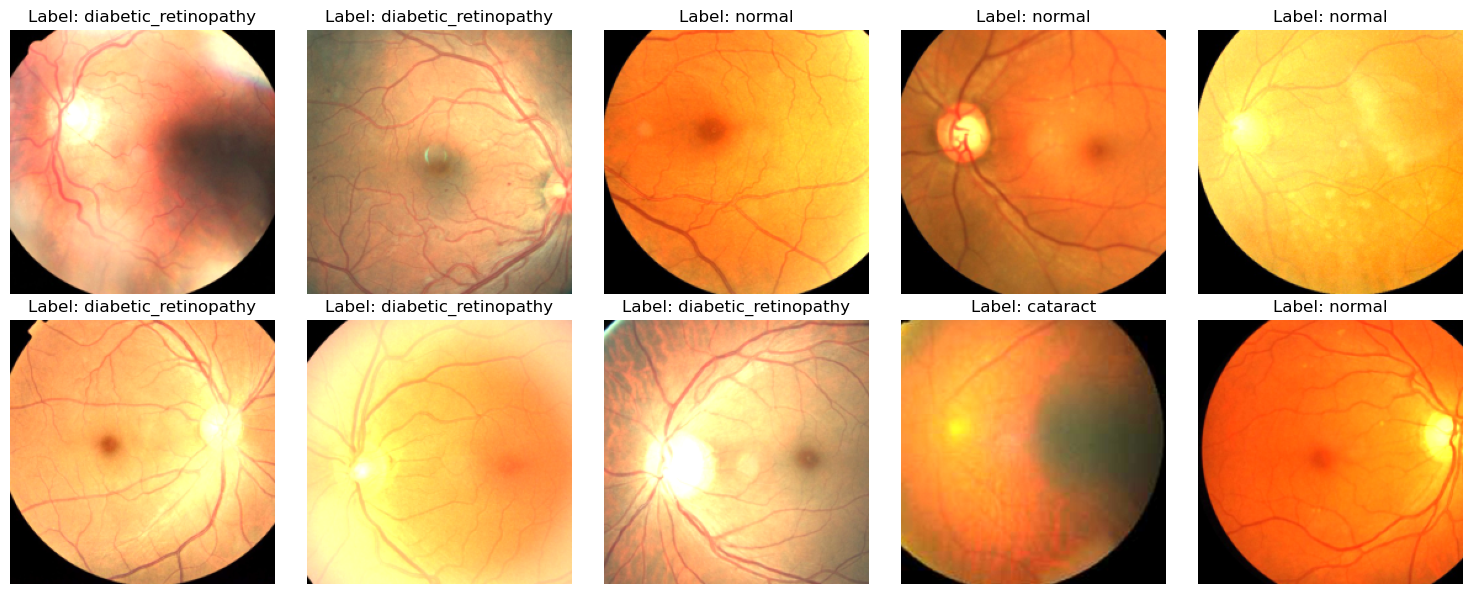

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Choose the dataset to visualize (train or val)
dataset = img_datasets['train']

# Select a few random samples from the dataset
samples = np.random.choice(len(dataset), size=10, replace=False)

# Plot the augmented images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, sample in enumerate(samples):
    row = i // 5
    col = i % 5
    
    image, label = dataset[sample]
    image = image.permute(1, 2, 0)  
    image = (image * torch.tensor([0.0014, 0.0012, 0.0007]).reshape(1, 1, -1)) + torch.tensor([0.0007, 0.0006, 0.0004]).reshape(1, 1, -1)  # Unnormalize the image
    axes[row, col].imshow(image)
    axes[row, col].set_title(f'Label: {class_names[label]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [7]:
model = models.densenet161(pretrained = True)

C:\Users\HP\.conda\envs\ForML\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\.conda\envs\ForML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# freezing the layers of the pre-trained model
# i = 0
for freeze_parameters in model.parameters():
    freeze_parameters.requires_grad = False

total_params = sum(p.numel() for p in model.parameters())
print(total_params)

28681000


In [9]:
import torch.nn as nn

num_input_features = model.classifier.in_features
print(num_input_features)
model.classifier = nn.Linear(num_input_features, 4)

2208


In [10]:
criteration = nn.CrossEntropyLoss()

In [11]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [12]:
# set the divice 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# move the model to the device
model = model.to(device)

num_epochs = 10

best_loss = float('inf')
best_weights = None

for epoch in range(num_epochs):
    since = time.time()
    running_loss = 0.0
    running_corrects = 0
    val_loss = 0.0
    val_corrects = 0
    
    # set the model in training mode
    model.train()

    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        features = model(inputs)
        outputs = features

        # compute the loss
        loss = criteration(outputs, labels)

        # backward pass
        loss.backward()

        # update the parameter
        optimizer.step()

        # calculate training accuracy
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # calculate training loss and accuracy
    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']

    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward pass
            features = model(inputs)
            outputs = features

            # calculate the loss
            val_loss += criteration(outputs, labels).item() * inputs.size(0)

            # calculate validation accuracy
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    # calculate validation loss and accuracy
    val_loss = val_loss / dataset_sizes['validation']
    val_acc = val_corrects.double() / dataset_sizes['validation']

    # Check if current validation loss is better than the best loss
    if val_loss < best_loss:
        best_loss = val_loss
        best_weights = model.state_dict()

    # Print epoch, training loss, training accuracy, validation loss, and validation accuracy
    print(f'Epoch {epoch+1}/{num_epochs}: Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

time_elapsed = time.time() - since
print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

# Load the best weights
model.load_state_dict(best_weights)


Epoch 1/10: Training Loss: 0.7817 Acc: 0.7005, Validation Loss: 0.6735 Acc: 0.6921
Epoch 2/10: Training Loss: 0.5601 Acc: 0.7850, Validation Loss: 0.7602 Acc: 0.6325
Epoch 3/10: Training Loss: 0.5105 Acc: 0.8105, Validation Loss: 0.7894 Acc: 0.6325
Epoch 4/10: Training Loss: 0.4800 Acc: 0.8218, Validation Loss: 0.7895 Acc: 0.6611
Epoch 5/10: Training Loss: 0.4521 Acc: 0.8289, Validation Loss: 0.6846 Acc: 0.6826
Epoch 6/10: Training Loss: 0.4297 Acc: 0.8292, Validation Loss: 0.6846 Acc: 0.6945
Epoch 7/10: Training Loss: 0.4030 Acc: 0.8499, Validation Loss: 0.7302 Acc: 0.6611
Epoch 8/10: Training Loss: 0.4147 Acc: 0.8449, Validation Loss: 0.8816 Acc: 0.5823
Epoch 9/10: Training Loss: 0.3980 Acc: 0.8538, Validation Loss: 0.7375 Acc: 0.6683
Epoch 10/10: Training Loss: 0.3773 Acc: 0.8624, Validation Loss: 0.7004 Acc: 0.6850
Training complete in 11m 32s


<All keys matched successfully>

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score

In [14]:
# Calculate test accuracy, precision, and recall
test_corrects = 0
predicted_labels = []
true_labels = []
model.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        features = model(inputs)
        outputs = features

        # Calculate test accuracy
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

        # Store predicted and true labels for confusion matrix
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
# Calculate test accuracy
test_acc = test_corrects.double() / dataset_sizes['test']

# Calculate confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')

In [15]:
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('Confusion Matrix:')
print(confusion_mat)

Test Accuracy: 0.5704
Precision: 0.6428
Recall: 0.5704
Confusion Matrix:
[[58  0 47  0]
 [ 2 76 19 14]
 [37  0 65  0]
 [ 3 11 50 44]]


In [16]:
class_names = dataloaders['test'].dataset.classes
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

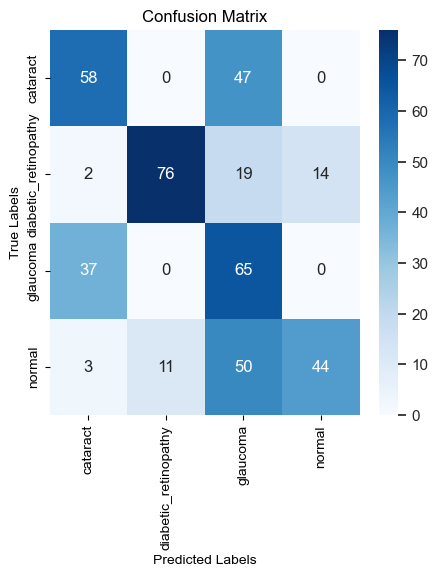

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.set(font_scale=1.0)  # Adjust font size as needed
sns.heatmap(
    confusion_mat,
    annot=True,
    fmt='d',
    cmap="Blues",  # You can choose a different color palette
    xticklabels=class_names,
    yticklabels=class_names,
)
# ax.set_xticklabels(class_names, rotation=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()